## 2 attack

Транзакции заменяются выборочно из `0plotting.ipynb`

In [1]:
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
from model import predict # Функция, позволяет получить предсказание нейронки.
from check_budget import check_budget # функция проверки бюджета. Проверяйте допустимость решения до сабмита
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

bins_path = "nn_bins.pickle" # путь до файла с бинами после тренировки модели (nn_bins.pickle)
model_path = "nn_weights.ckpt" # путь до файла с весами нейронной сети (nn_weights.ckpt)
quantiles_path = "quantiles.json" # путь до файла с квантилями для таргета (quantiles.pickle)

transactions_path = "../sample_submission.csv"    # путь до файла с транзакциями, которые атакуются

train_data_path = "../transactions_finetune.csv" # X - train data
train_target_path = "../target_finetune.csv" # y - true target

In [2]:
seed = 26041999
BUDGET = 10 # разрешенное количество изменений транзакций для каждого пользователя - N транзакций
threshold = pd.read_csv(train_target_path).target.mean() # примерный threshold трейна

In [3]:
train_df = pd.read_csv(train_data_path)
train_df.head()

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm
0,69,5541,48,-342.89792,2021-03-05 02:52:36
1,69,5533,48,-1251.88120,2021-03-05 09:43:28
2,69,5331,48,-87.30924,2021-03-05 11:17:23
3,69,5921,48,-1822.17700,2021-03-05 13:41:03
4,69,5311,48,-427.12363,2021-03-05 19:14:23


In [4]:
train_df.loc[train_df.user_id == 69].index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            290, 291, 292, 293, 294, 295, 296, 297, 298, 299],
           dtype='int64', length=300)

In [5]:
train_df.iloc[:2]

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm
0,69,5541,48,-342.89792,2021-03-05 02:52:36
1,69,5533,48,-1251.88120,2021-03-05 09:43:28


In [21]:
import pytorch_lightning as pl
import torch
import pickle
from model import process_for_nn, TransactionsDataset, get_dataloader, device, TransactionsRnn

pl.seed_everything(seed)
model = TransactionsRnn()
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()


def create_dl(source_file, bins_path):
    df_transactions = (
        pd.read_csv(
            source_file,
            parse_dates=["transaction_dttm"],
            dtype={"user_id": int, "mcc_code": int, "currency_rk": int, "transaction_amt": float},
        )
        .dropna()
        .assign(
            hour=lambda x: x.transaction_dttm.dt.hour,
            day=lambda x: x.transaction_dttm.dt.dayofweek,
            month=lambda x: x.transaction_dttm.dt.month,
            number_day=lambda x: x.transaction_dttm.dt.day,
        )
    )

    with open(bins_path, "rb") as f:
        bins = pickle.load(f)

    features = bins.pop("features")
    df = process_for_nn(df_transactions, features, bins)
    dataset = TransactionsDataset(df)
    dataloader = get_dataloader(dataset, device, is_validation=True)
    return dataloader


def predictor(dataloader, model):
    preds = []
    users = []
    for data, target in dataloader:
        y_pred = model(data)
        preds.append(y_pred.detach().cpu().numpy())
        users.append(target.detach().cpu().numpy())
    preds = np.concatenate(preds)
    users = np.concatenate(users)
    return pd.DataFrame({"user_id": users, "target": preds[:, 1]})

Global seed set to 26041999


In [22]:
def check_predict_for_index(train_df, user_id, model):
    pl.seed_everything(26041999)
    output_path = 'temp.csv'
    idx_list = train_df.loc[train_df.user_id == user_id].index
    df = pd.DataFrame()
    for i in idx_list:
        train_df.loc[train_df.index == i].to_csv(output_path)
        dataloader = create_dl(output_path, bins_path)
        result = predictor(dataloader, model)
        df = pd.concat([df, result])
    return df.set_index(idx_list)

In [35]:
check_predic0 = check_predict_for_index(train_df, 69, model)

Global seed set to 26041999


In [36]:
check_predic0

,user_id,target
0,69,0.064805
1,69,0.045921
2,69,0.065678
3,69,0.042273
4,69,0.044479
...,...,...
295,69,0.057109
296,69,0.052098
297,69,0.039629
298,69,0.062488


In [91]:
train_pred = predict(train_data_path, bins_path, model_path, random_seed=seed)
train_true = pd.read_csv(train_target_path).rename(columns={'target': 'target_true'})
train_pred = train_pred.merge(train_true, how='left', on='user_id')
train_pred['target_threshold'] = train_pred.target.apply(lambda x: 0 if x <= threshold else 1)

Global seed set to 26041999


In [92]:
# roc auc для train ds
roc_auc_score(train_pred.target_true, train_pred.target)

0.6696592316253115

In [94]:
# roc auc для threshold
roc_auc_score(train_pred.target_true, train_pred.target_threshold)

0.6271337210213647

In [93]:
train_pred.loc[train_pred.target_true == 0].sort_values('target')

,user_id,target,target_true,target_threshold
3517,430861,0.000449,0,0
3204,388082,0.000489,0,0
3087,373763,0.000558,0,0
6197,759049,0.000609,0,0
6157,753340,0.000631,0,0
...,...,...,...,...
2707,326303,0.365463,0,1
839,104786,0.370416,0,1
1899,228615,0.389207,0,1
3770,464184,0.420699,0,1


In [90]:
train_pred.loc[train_pred.target_true == 1].sort_values('target')

,user_id,target,target_true
2464,296241,0.000741,1
2971,360883,0.001684,1
3011,365734,0.002392,1
6085,743592,0.002655,1
4667,571838,0.002791,1
...,...,...,...
3750,462375,0.269094,1
3280,398490,0.269145,1
2280,274308,0.282332,1
2001,239542,0.327631,1


In [67]:
train_pred.loc[train_pred.user_id == 430861] # min

,user_id,target,target_true
3517,430861,0.000449,0


In [68]:
train_pred.loc[train_pred.user_id == 469439] # max

,user_id,target,target_true
3807,469439,0.422741,0


In [45]:
check_predic_min = check_predict_for_index(train_df, 430861, model)
check_predic_max = check_predict_for_index(train_df, 469439, model)

Global seed set to 26041999
Global seed set to 26041999


In [50]:
check_predic_min.target.describe()

count    300.000000
mean       0.054023
std        0.015149
min        0.018056
25%        0.043878
50%        0.052734
75%        0.062493
max        0.109097
Name: target, dtype: float64

In [51]:
check_predic_max.target.describe()

count    300.000000
mean       0.060306
std        0.016226
min        0.024097
25%        0.049018
50%        0.057344
75%        0.070436
max        0.127171
Name: target, dtype: float64

In [69]:
check_predic_min

,user_id,target
1055100,430861,0.055836
1055101,430861,0.032516
1055102,430861,0.053721
1055103,430861,0.039562
1055104,430861,0.072525
...,...,...
1055395,430861,0.073660
1055396,430861,0.061849
1055397,430861,0.054746
1055398,430861,0.056289


In [70]:
check_predic_max

,user_id,target
1142100,469439,0.058630
1142101,469439,0.043781
1142102,469439,0.067741
1142103,469439,0.073305
1142104,469439,0.050287
...,...,...
1142395,469439,0.086441
1142396,469439,0.055393
1142397,469439,0.050169
1142398,469439,0.050144


In [72]:
train_pred.target_true.value_counts()

0    6818
1     262
Name: target_true, dtype: int64

In [133]:
random.seed(20230206)
###############################################
# testing df_train last 10
##############################################
hero_user_train = 469439 # настоящий 0, предсказали 1
print(hero_user_train)
poor_user_train = 296241 # настоящий 1, предсказали 0
print(poor_user_train)

random.seed(10032023)

# threshold = pd.read_csv("../data/target_finetune.csv").target.mean()  # вероятность, по которой мы считаем таргет

df_transactions = pd.read_csv(
    transactions_path,
    parse_dates=["transaction_dttm"],
    dtype={"user_id": int, "mcc_code": int, "currency_rk": int, "transaction_amt": float},
)

bins_path = "nn_bins.pickle"
model_path = "nn_weights.ckpt"
target = predict(transactions_path, bins_path, model_path)

one_idx = target.index[target.target > threshold]  # Эти пользователи похожи на Героя
zero_idx = target.index[target.target <= threshold] # А эти на Неудачника

users = target.user_id.values

one_users = users[one_idx] # defolt - 1
zero_users = users[zero_idx] # norm users - 0

for user in tqdm(users):
    if user in one_users:
        copy_from = poor_user_train # похожим на Героя скопируем 10 последних транзакций Неудачника
    else:
        copy_from = hero_user_train # А похожим на Неудачника наоборот

    idx_to = df_transactions.index[df_transactions.user_id == user][:BUDGET] # айдишники последних 10 транзакций юзера
    idx_from = train_df.index[train_df.user_id == copy_from][:BUDGET] # айдишники последних 10 транзакций воннаби

    sign_to = np.sign(df_transactions.loc[idx_to, "transaction_amt"].values)
    sign_from = np.sign(df_transactions.loc[idx_from, "transaction_amt"].values)
    sign_mask = (sign_to == sign_from)

    df_transactions.loc[idx_to[sign_mask], "mcc_code"] = train_df.loc[idx_from[sign_mask], "mcc_code"].values
    df_transactions.loc[idx_to[sign_mask], "transaction_amt"] = train_df.loc[idx_from[sign_mask], "transaction_amt"].values

output_path = "train_attack_2_first_10_budget.csv"
df_transactions.to_csv(output_path, index=False)

469439
296241


Global seed set to 26041999
100%|█████████████████████████████████████████████████████████████████████████████| 4200/4200 [00:19<00:00, 219.10it/s]


In [96]:
# ROC-AUC Diff
def roc_auc_diff(attacked_path, transactions_path, threshold=None):
    result = predict(transactions_path, bins_path, model_path, random_seed=seed)
    attacked = predict(output_path, bins_path, model_path, random_seed=seed)

    if not threshold:
        threshold = pd.read_csv(train_target_path).target.mean() # примерный threshold трейна

    target_attack = attacked.rename(columns={'target': 'target_attack'})
    target_attack['target_pred_true'] = result.target
    target_attack['target_true'] = result.target.apply(lambda x: 0 if x <= threshold else 1)

    roc_auc_orig = roc_auc_score(target_attack.target_true, target_attack.target_pred_true)
    roc_auc_attack = roc_auc_score(target_attack.target_true, target_attack.target_pred_true) -\
                     roc_auc_score(target_attack.target_true, target_attack.target_attack)
    print('ROC-AUC original', roc_auc_orig)
    print('ROC-AUC attacked', roc_auc_score(target_attack.target_true, target_attack.target_attack))
    print('DIF ROC-AUC', roc_auc_attack)
    return target_attack

In [102]:
# first 10 BUDGET
roc_auc_diff(output_path, transactions_path, threshold=threshold)

Global seed set to 26041999
Global seed set to 26041999


ROC-AUC original 1.0
ROC-AUC attacked 0.7399958022092175
DIF ROC-AUC 0.26000419779078254


,user_id,target_attack,target_pred_true,target_true
0,66,0.038557,0.027909,0
1,213,0.027684,0.019507,0
2,345,0.110239,0.162300,1
3,569,0.015531,0.084853,1
4,573,0.024134,0.016584,0
...,...,...,...,...
4195,868183,0.025564,0.016348,0
4196,868407,0.010220,0.046630,1
4197,868573,0.018572,0.037443,1
4198,868694,0.036789,0.016083,0


In [98]:
# last 10 BUDGET
roc_auc_diff(output_path, transactions_path, threshold=threshold)

Global seed set to 26041999
Global seed set to 26041999


ROC-AUC original 1.0
ROC-AUC attacked 0.8774222789196562
DIF ROC-AUC 0.12257772108034382


,user_id,target_attack,target_pred_true,target_true
0,66,0.040443,0.027909,0
1,213,0.038201,0.019507,0
2,345,0.082199,0.162300,1
3,569,0.066386,0.084853,1
4,573,0.022994,0.016584,0
...,...,...,...,...
4195,868183,0.027643,0.016348,0
4196,868407,0.037918,0.046630,1
4197,868573,0.022650,0.037443,1
4198,868694,0.007569,0.016083,0


In [149]:
random.seed(20230206)
###############################################
# testing df_train last 10
##############################################
hero_user_train = 469439 # настоящий 0, предсказали 1
print(hero_user_train)
poor_user_train = 296241 # настоящий 1, предсказали 0
print(poor_user_train)

random.seed(10032023)

# threshold = pd.read_csv("../data/target_finetune.csv").target.mean()  # вероятность, по которой мы считаем таргет

df_transactions = pd.read_csv(
    transactions_path,
    parse_dates=["transaction_dttm"],
    dtype={"user_id": int, "mcc_code": int, "currency_rk": int, "transaction_amt": float},
)

bins_path = "nn_bins.pickle"
model_path = "nn_weights.ckpt"
target = predict(transactions_path, bins_path, model_path)

one_idx = target.index[target.target > threshold]  # Эти пользователи похожи на Героя
zero_idx = target.index[target.target <= threshold] # А эти на Неудачника

users = target.user_id.values

one_users = users[one_idx] # defolt - 1
zero_users = users[zero_idx] # norm users - 0

for user in tqdm(users):
    if user in one_users:
        copy_from = poor_user_train # похожим на Героя скопируем 10 последних транзакций Неудачника
    else:
        copy_from = hero_user_train # А похожим на Неудачника наоборот

    idx_to_first = df_transactions.index[df_transactions.user_id == user][:5] # айдишники последних 10 транзакций юзера
    idx_from_first = train_df.index[train_df.user_id == copy_from][:5] # айдишники последних 10 транзакций воннаби

    idx_to_last = df_transactions.index[df_transactions.user_id == user][-5:] # айдишники последних 10 транзакций юзера
    idx_from_last = train_df.index[train_df.user_id == copy_from][-5:] # айдишники последних 10 транзакций воннаби

    idx_to = idx_to_first.append(idx_to_last)
    idx_from = idx_from_first.append(idx_from_last)

    sign_to = np.sign(df_transactions.loc[idx_to, "transaction_amt"].values)
    sign_from = np.sign(df_transactions.loc[idx_from, "transaction_amt"].values)
    sign_mask = (sign_to == sign_from)

    df_transactions.loc[idx_to[sign_mask], "mcc_code"] = train_df.loc[idx_from[sign_mask], "mcc_code"].values
    df_transactions.loc[idx_to[sign_mask], "transaction_amt"] = train_df.loc[idx_from[sign_mask], "transaction_amt"].values

output_path = "train_attack_2_first_5_last_5_budget.csv"
df_transactions.to_csv(output_path, index=False)

469439
296241


Global seed set to 26041999
100%|█████████████████████████████████████████████████████████████████████████████| 4200/4200 [00:31<00:00, 132.80it/s]


In [152]:
threshold

0.037005649717514126

In [157]:
# first 5 and last 5 BUDGET
roc_auc_diff(output_path, transactions_path, threshold=threshold)

Global seed set to 26041999
Global seed set to 26041999


ROC-AUC original 1.0
ROC-AUC attacked 0.7729225643892537
DIF ROC-AUC 0.22707743561074634


,user_id,target_attack,target_pred_true,target_true
0,66,0.028324,0.027909,0
1,213,0.024722,0.019507,0
2,345,0.070444,0.162300,1
3,569,0.019623,0.084853,1
4,573,0.020954,0.016584,0
...,...,...,...,...
4195,868183,0.043811,0.016348,0
4196,868407,0.010597,0.046630,1
4197,868573,0.013359,0.037443,1
4198,868694,0.004208,0.016083,0


In [ ]:
# threshold: 0.037005
# pred       true
# 0.227077 = 0.036633
# 0.26000 = 0.055154
# 0.12257 = 0.04643

In [113]:
df_transactions

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm
0,66,5411,48,-124.323170,2021-05-17 11:30:42
1,66,5411,48,-53.718437,2021-05-17 12:59:02
2,66,5411,48,-110.978360,2021-05-17 14:04:09
3,66,4111,48,10.971557,2021-05-17 15:03:10
4,66,5921,48,-83.012825,2021-05-17 15:33:43
...,...,...,...,...,...
1259995,868873,5411,48,-193.739270,2021-06-27 09:25:53
1259996,868873,5921,48,-155.684170,2021-06-29 07:00:31
1259997,868873,5921,48,-142.909380,2021-06-30 02:26:42
1259998,868873,5411,48,-116.532200,2021-06-30 11:34:35


In [244]:
random.seed(20230206)
###############################################
# testing df_train last 10
##############################################
hero_user_train = 469439 # настоящий 0, предсказали 1
print(hero_user_train)
poor_user_train = 296241 # настоящий 1, предсказали 0
print(poor_user_train)

random.seed(10032023)

# threshold = pd.read_csv("../data/target_finetune.csv").target.mean()  # вероятность, по которой мы считаем таргет

df_transactions = pd.read_csv(
    transactions_path,
    parse_dates=["transaction_dttm"],
    dtype={"user_id": int, "mcc_code": int, "currency_rk": int, "transaction_amt": float},
)

bins_path = "nn_bins.pickle"
model_path = "nn_weights.ckpt"
target = predict(transactions_path, bins_path, model_path)

one_idx = target.index[target.target > threshold]  # Эти пользователи похожи на Героя
zero_idx = target.index[target.target <= threshold] # А эти на Неудачника

users = target.user_id.values

one_users = users[one_idx] # defolt - 1
zero_users = users[zero_idx] # norm users - 0

for user in tqdm(users):
    if user in one_users:
        copy_from = poor_user_train # похожим на Героя скопируем 10 последних транзакций Неудачника
    else:
        copy_from = hero_user_train # А похожим на Неудачника наоборот

    idx_to = df_transactions.index[df_transactions.user_id == user][:10]
    idx_from = train_df.index[train_df.user_id == copy_from][:10]

    sign_to = np.sign(df_transactions.loc[idx_to, "transaction_amt"].values)
    sign_from = np.sign(df_transactions.loc[idx_from, "transaction_amt"].values)
    sign_mask = (sign_to == sign_from)

    df_transactions.loc[idx_to[sign_mask], "mcc_code"] = train_df.loc[idx_from[sign_mask], "mcc_code"].values
    df_transactions.loc[idx_to[sign_mask], "transaction_amt"] = train_df.loc[idx_from[sign_mask], "transaction_amt"].values

output_path = "train_attack_2_random_10_budget.csv"
df_transactions.to_csv(output_path, index=False)

469439
296241


Global seed set to 26041999
100%|█████████████████████████████████████████████████████████████████████████████| 4200/4200 [00:19<00:00, 218.23it/s]


In [245]:
# random 10 BUDGET
roc_auc_diff(output_path, transactions_path, threshold=threshold)

Global seed set to 26041999
Global seed set to 26041999


ROC-AUC original 1.0
ROC-AUC attacked 0.7399958022092175
DIF ROC-AUC 0.26000419779078254


,user_id,target_attack,target_pred_true,target_true
0,66,0.038557,0.027909,0
1,213,0.027684,0.019507,0
2,345,0.110239,0.162300,1
3,569,0.015531,0.084853,1
4,573,0.024134,0.016584,0
...,...,...,...,...
4195,868183,0.025564,0.016348,0
4196,868407,0.010220,0.046630,1
4197,868573,0.018572,0.037443,1
4198,868694,0.036789,0.016083,0


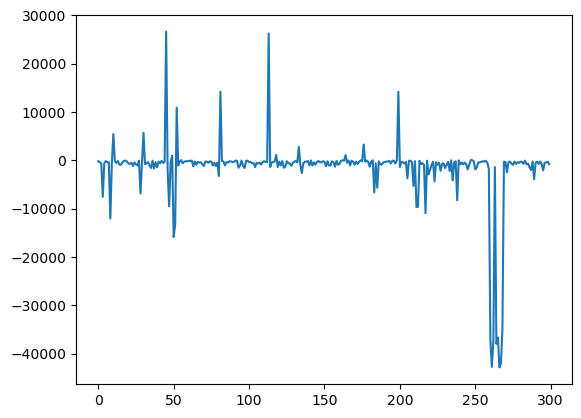

In [236]:
df = pd.read_csv(train_data_path)

plt.plot(range(300), df.loc[df.user_id == poor_user_train].transaction_amt.values)

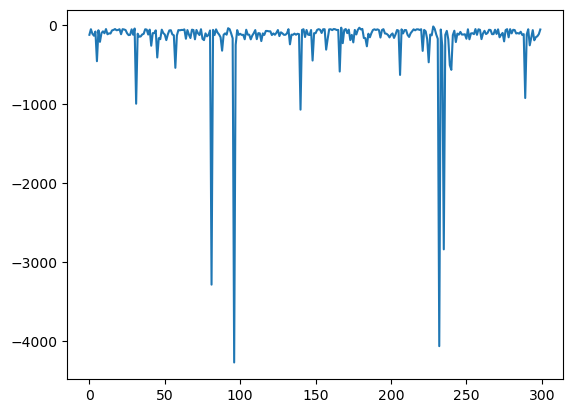

In [237]:
plt.plot(range(300), df.loc[df.user_id == hero_user_train].transaction_amt.values)